In [27]:
#!pip install numpy pandas matplotlib scikit-learn tensorflow keras

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import os

## Carregando os dados e colocando a coluna 'Date' como índice

In [29]:
caminho_pasta = 'Base_dados'
lista_arquivos = [arquivo for arquivo in os.listdir(caminho_pasta) if os.path.isfile(os.path.join(caminho_pasta, arquivo))]

for arq in lista_arquivos:
    #converte a coluna 'Date' para o tipo datetime
    df = pd.read_csv(f'Base_dados/{arq}', parse_dates=['Date'])
    df = df.sort_values('Date')
    # Verificar se a coluna 'Date' existe e definir como índice
    # if 'Date' in df.columns:
    #     df = df.set_index('Date')
    print(df.head())


        Date    Open       High        Low      Close  Adj Close      Volume  \
0 2020-01-29  25.500  25.690001  24.680000  24.730000  18.055990  16800400.0   
1 2020-01-30  24.350  24.995001  24.184999  24.900000  18.180117  25079800.0   
2 2020-01-31  24.555  24.559999  24.110001  24.270000  17.720137  32252800.0   
3 2020-02-03  24.275  24.570000  24.004999  24.389999  17.807749  20402800.0   
4 2020-02-04  24.645  24.799999  24.125000  24.125000  17.614269  23533200.0   

    SMA_10     EMA_10     RSI_10      MACD  MACD_Histogram  BBL_20_2.0  \
0  24.9610  25.132101  40.316762 -0.407259        0.043456   23.842415   
1  24.9785  25.089901  43.272728 -0.397243        0.042777   23.898938   
2  24.8995  24.940828  35.942692 -0.435126        0.003916   23.906795   
3  24.8485  24.840677  38.159656 -0.450275       -0.008986   23.925546   
4  24.8430  24.710554  35.172752 -0.478152       -0.029490   23.906871   

   BBM_20_2.0  BBU_20_2.0  BBB_20_2.0  BBP_20_2.0   ATRr_14    stoch_k  \


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1174 non-null   datetime64[ns]
 1   Open            1174 non-null   float64       
 2   High            1174 non-null   float64       
 3   Low             1174 non-null   float64       
 4   Close           1174 non-null   float64       
 5   Adj Close       1174 non-null   float64       
 6   Volume          1174 non-null   float64       
 7   SMA_10          1174 non-null   float64       
 8   EMA_10          1174 non-null   float64       
 9   RSI_10          1174 non-null   float64       
 10  MACD            1174 non-null   float64       
 11  MACD_Histogram  1174 non-null   float64       
 12  BBL_20_2.0      1174 non-null   float64       
 13  BBM_20_2.0      1174 non-null   float64       
 14  BBU_20_2.0      1174 non-null   float64       
 15  BBB_

# 1 - Pré-Processamento dos Dados

## 1.1 - Selecionar Colunas Relevantes

In [31]:
#hist_TSLA
data = df['Close'].values

## 1.2 - Criação de Variável Alvo (Classificação)
Como você mencionou métricas como acurácia, falso negativo e F1-score, que são usadas em problemas de classificação, vamos converter o problema em uma tarefa de classificação binária (por exemplo, prever se o preço da ação vai subir ou descer no próximo dia).

In [32]:
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

## 1.3 - Seleção de Recursos (Features)

In [33]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df[features].values
y = df['Target'].values

## 1.4 - Normalização dos Dados

In [34]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2 - Criação de Sequências para Treinamento

In [35]:
# Defina o tamanho da janela de tempo (por exemplo, 60 dias):
window_size = 60

# Criando sequências de dados
def create_sequences(data, target, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)




# 3 - Redimensionamento dos Dados

In [36]:
# Redimensionando X para 3 dimensões (necessário para Conv1D)
X = np.expand_dims(X, axis=2)

# 5 - Construção do Modelo CNN

In [37]:
model = Sequential()

## 5.2 - Compilando Modelo

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 10 - Análise Estatística ao Longo dos Anos

## 10.1 - Preparar dados para Múltiplos Anos:

Vamos dividir os dados por ano e treinar/testar o modelo para cada ano, coletando as métricas de desempenho para calcular a média e o desvio padrão.

In [39]:
#Inicializar listas para armazenar métricas:
accuracies = []
precisions = []
recalls = []
f1_scores = []
years_list = []

#Obter os anos únicos no dataframe:
df['Date'] = pd.to_datetime(df['Date'])
years = df['Date'].dt.year.unique()

for year in years:
    # Filtrar dados do ano atual
    df_year = df[df['Date'].dt.year == year].reset_index(drop=True)
    
    # Verificar se há dados suficientes
    if len(df_year) > window_size:
        # Selecionar as features e o alvo
        X_data = df_year[features].values
        y_data = df_year['Target'].values
        
        # Criar sequências
        X_sequences, y_sequences = create_sequences(X_data, y_data, window_size)
        
        # Dividir em treino e teste (70% treino, 30% teste)
        split = int(0.7 * len(X_sequences))
        X_train, X_test = X_sequences[:split], X_sequences[split:]
        y_train, y_test = y_sequences[:split], y_sequences[split:]
        
        # Construir o modelo
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, len(features))))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Treinar o modelo
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        
        # Avaliar o modelo
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Armazenar métricas
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        years_list.append(year)
        
        # Exibir resultados
        print(f"Ano: {year}")
        print(f"Acurácia: {accuracy:.4f}, Precisão: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}\n")
    else:
        print(f"Ano: {year} não possui dados suficientes para treinamento e teste.\n")

2/2 [==============================] - 0s 3ms/step
Ano: 2020
Acurácia: 0.5094, Precisão: 0.5510, Recall: 0.8710, F1-Score: 0.6750

2/2 [==============================] - 0s 3ms/step
Ano: 2021
Acurácia: 0.6034, Precisão: 0.6222, Recall: 0.8235, F1-Score: 0.7089

2/2 [==============================] - 0s 3ms/step
Ano: 2022
Acurácia: 0.6034, Precisão: 0.5385, Recall: 0.5600, F1-Score: 0.5490

2/2 [==============================] - 0s 3ms/step
Ano: 2023
Acurácia: 0.5263, Precisão: 0.5370, Recall: 0.9355, F1-Score: 0.6824

2/2 [==============================] - 0s 3ms/step
Ano: 2024
Acurácia: 0.6154, Precisão: 0.7143, Recall: 0.6250, F1-Score: 0.6667



## 10.2 - Calcular Média e Desvio Padrão da Acurácia

In [40]:
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_precision = np.mean(precisions)
std_precision = np.std(precisions)

mean_recall = np.mean(recalls)
std_recall = np.std(recalls)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Métricas Médias e Desvios Padrão:")
print(f"Acurácia Média: {mean_accuracy:.4f}, Desvio Padrão: {std_accuracy:.4f}")
print(f"Precisão Média: {mean_precision:.4f}, Desvio Padrão: {std_precision:.4f}")
print(f"Recall Médio: {mean_recall:.4f}, Desvio Padrão: {std_recall:.4f}")
print(f"F1-Score Médio: {mean_f1:.4f}, Desvio Padrão: {std_f1:.4f}")

Métricas Médias e Desvios Padrão:
Acurácia Média: 0.5716, Desvio Padrão: 0.0444
Precisão Média: 0.5926, Desvio Padrão: 0.0685
Recall Médio: 0.7630, Desvio Padrão: 0.1451
F1-Score Médio: 0.6564, Desvio Padrão: 0.0555


## 11 - Visualização dos Resultados ao Longo dos Anos

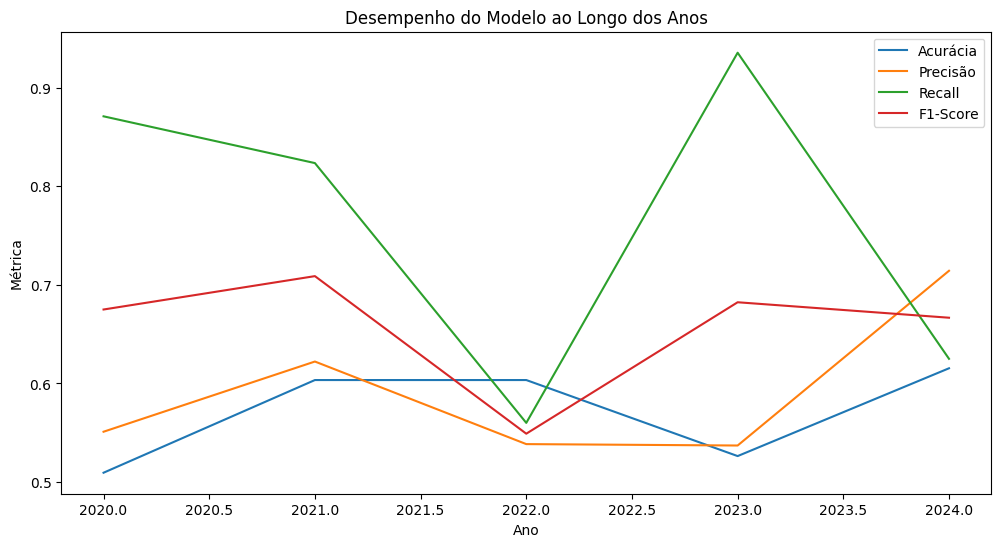

In [41]:
#Plotar métricas por ano

plt.figure(figsize=(12,6))
plt.plot(years_list, accuracies, label='Acurácia')
plt.plot(years_list, precisions, label='Precisão')
plt.plot(years_list, recalls, label='Recall')
plt.plot(years_list, f1_scores, label='F1-Score')
plt.xlabel('Ano')
plt.ylabel('Métrica')
plt.title('Desempenho do Modelo ao Longo dos Anos')
plt.legend()
plt.show()

# 12 - Testar Diversos Modelos

Para melhorar o desempenho, podemos testar diferentes modelos e arquiteturas.

Variar hiperparâmetros e arquiteturas:
- Alterar o número de filtros e o tamanho do kernel na camada Conv1D.
- Adicionar mais camadas convolucionais ou densas.
- Experimentar com diferentes funções de ativação.
- Ajustar o número de épocas e o tamanho do batch.

Comparar com outros modelos:
- LSTM: Modelos de Redes Neurais Recorrentes adequados para séries temporais.

In [42]:
# Substituir a camada Conv1D por LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(window_size, len(features))))
model.add(Dense(1, activation='sigmoid'))


Modelos Clássicos: Testar modelos como ARIMA ou Random Forest.

# 13 - Avaliação e Comparação dos Modelos
Armazenar resultados de diferentes modelos

In [43]:
results = []

# Após treinar e avaliar cada modelo, armazenar as métricas
results.append({
    'Modelo': 'CNN Básica',
    'Acurácia Média': mean_accuracy,
    'Desvio Padrão Acurácia': std_accuracy,
    'Precisão Média': mean_precision,
    'Desvio Padrão Precisão': std_precision,
    # ... outras métricas
})

In [44]:
# Comparar os modelos
# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibir a tabela comparativa
print(results_df)

       Modelo  Acurácia Média  Desvio Padrão Acurácia  Precisão Média  \
0  CNN Básica        0.571606                0.044409        0.592605   

   Desvio Padrão Precisão  
0                0.068457  


Documentação e Análise Final

Documentar cada experimento:
- Descrever a arquitetura do modelo.
- Listar os hiperparâmetros utilizados.
- Apresentar as métricas de desempenho.

Análise Crítica:
- Identificar quais modelos apresentaram melhor desempenho e possíveis razões.
- Discutir a consistência dos resultados ao longo dos anos.
- Considerar fatores externos que podem ter influenciado os resultados (por exemplo, eventos econômicos).

Conclusões:
- Resumir os principais achados do estudo.
- Sugerir melhorias para trabalhos futuros.
- Destacar a importância de utilizar múltiplos anos de dados para obter resultados estatisticamente significativos.

Considerações Finais

- Manutenção da Ordem Temporal: É essencial manter a sequência temporal dos dados em problemas de séries temporais para evitar vazamento de informações e obter previsões realistas.
- Validação Cruzada em Séries Temporais: Em vez de usar a validação cruzada tradicional, utilize técnicas específicas para séries temporais, como a divisão em blocos temporais.
- Análise de Métricas: Além da acurácia, utilize métricas como precisão, recall e F1-score para uma avaliação mais completa do modelo, especialmente em casos de classes desbalanceadas.
- Reprodutibilidade: Garanta que todo o código e experimentos sejam reprodutíveis, documentando as versões das bibliotecas e fixando seeds aleatórias quando necessário.

Dicas Adicionais

- Exploração de Dados: Realize uma análise exploratória dos dados para entender padrões e tendências que possam ser úteis no modelo.
- Feature Engineering: Considere criar novas features, como indicadores técnicos (Médias Móveis, RSI, etc.), que podem melhorar o desempenho do modelo.
- Regularização e Overfitting: Utilize técnicas como Dropout, Early Stopping e Regularização L2 para prevenir overfitting.
- Interpretação do Modelo: Embora modelos de deep learning sejam frequentemente considerados "caixas pretas", ferramentas como SHAP e LIME podem ajudar a interpretar as previsões.